In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
from statsmodels.tsa.arima.model import ARIMA 
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.functional as F
from torch import optim
from sklearn.decomposition import PCA

sys.path.append('../')

from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, SelfAttentionEncoder, OrthoLoss
from Andreini_data.data import load_y
from torch.autograd.functional import jacobian


## Implementing the MCMC procedure as proposed by Andreini 
We consider the model
$$
\mathbf{\mathbb{f}}_t = G(\mathbf{y}_t) \\ 
\mathbf{y}_t = F(\mathbf{\mathbb{f}}_t) + \mathbf{\varepsilon}_t \\ 
\mathbf{\mathbb{f}}_t = \mathbf{B}_1 \mathbf{f}_{t-1} + \cdots + \mathbf{B}_p \mathbf{f}_{t-p} + \mathbf{u}_t \\
\mathbf{\varepsilon}_t = \mathbf{\Phi_1} \mathbf{\varepsilon}_{t-1} + \cdots \mathbf{\Phi_d} \mathbf{\varepsilon}_{t-d} + \mathbf{\epsilon}_t 
$$


In [17]:
class ArProcess():
    """
    class containing the autoregressive processes of the idiosyncratic error terms \varepsilon_t
    This should be a var process if Q can be nondiagonal
    """
    def __init__(self, T:int, n:int, d:int):
        self.n = n
        self.T = T 
        self.d = d #number of lags
        self.parameters = None
        x = np.zeros((T,n)) #start with empty data
        self.models = [ARIMA(order=(self.d,0,0), trend='n', endog=x[:,i]) for i in range(x.shape[1])]


    def fit(self, x):
        self.models = [ARIMA(order=(self.d,0,0), trend='n', endog=x[:,i]) for i in range(x.shape[1])]
        self.fitted = [mod.fit(method='yule_walker') for mod in self.models]
        return self

    @property
    def coefficients(self):
        """
        Return estimated coefficients of the ar() processes
        """
        return np.stack([_.params[0] for _ in self.fitted])
    
    def sigma2(self):
        """
        Return estimated residual sigma_2 of the processes
        """
        return np.stack([_.params[1] for _ in self.fitted])

    def conditionalExpectation(self):
        """
        obtain Phi(L)eps_t
        """
        return np.stack([mod.predict() for mod in self.fitted]).T
    
    def initialize(self):
        for mod in self.models:
            mod.initialize_stationary()
            
    def simulate(self):
        return np.stack([mod.simulate(nsimulations=self.T) for mod in self.fitted]).T

In [18]:
n = 10
T = 100
eps = np.random.normal(size = (T,n))
print(eps.shape)
ar = ArProcess(T,n,1)
ar.fit(eps)
pred = ar.conditionalExpectation()
print(pred.shape)
sim = ar.simulate()
sim.shape

(100, 10)
(100, 10)


(100, 10)

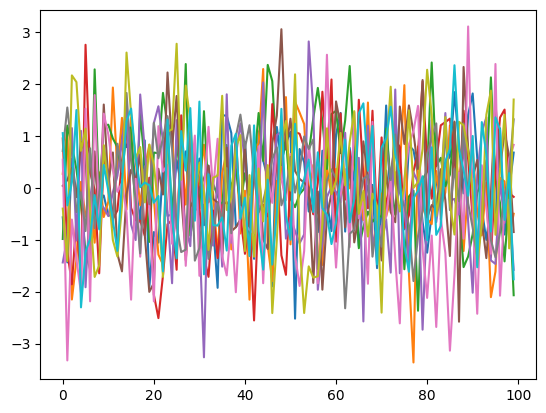

In [4]:
#plt.plot(eps.T);
plt.plot(sim);

In [5]:
mu = np.array([0,0,0,90,990,1,1])
sig = np.array([1,1,1,1,1,1,1])
np.random.multivariate_normal(mu, np.diag(sig), size=(10)).shape

(10, 7)

In [2]:
# A step-up version where error terms epsilon_t are iid instead of ar process
def check_convergence(loss_hist: list, eps = 1e-10):
    if len(loss_hist) < 11:
        return False
    if len(loss_hist) > 1000:
        return True
    return ((np.array(loss_hist)[-11:-1] - np.array(loss_hist)[-10:]) < eps).all()

def init_eps(T:int,n:int):
    """
    Initinitalize idiosyncratic error terms.
    """
    #TODO: How to do this lol?
    eps = np.random.normal(size = (T,n), scale=0.01)
    return eps, np.mean(eps,axis=0), np.var(eps, axis=0)

def d2FMMCMC_iid(y: np.ndarray, model: AutoEncoder, n_epoch:int, optimizer: optim.Optimizer, criterion: nn.Module):
    n = y.shape[1]
    T = y.shape[0]
    eps, mu_eps, sigma_eps = init_eps(T,n)
    convergence = False

    hist_keys = ['loss', 'eps', 'mu_eps', 'var_eps']
    train_hist = {k: [] for k in hist_keys}

    y_tensor = torch.from_numpy(y).float()
    i = 0
    while not convergence:
        y_tilde = y - mu_eps
        for epoch in range(n_epoch):
            y_tilde_mc = y_tilde + np.random.multivariate_normal(mu_eps, np.diag(sigma_eps), size=(T))
            optimizer.zero_grad()
            model_in = torch.from_numpy(y_tilde_mc).float()
            out = model(model_in)
            loss  = criterion(out, model_in)
            loss.backward()
            optimizer.step()
            train_hist['loss'].append(loss.item())
        eps = y - model(y_tensor).detach().numpy()
        sigma_eps = np.var(eps, axis=0)
        mu_eps = np.mean(eps,axis=0)
        train_hist['eps'].append(eps)
        train_hist['mu_eps'].append(mu_eps)
        train_hist['var_eps'].append(sigma_eps)
        print(i, train_hist['loss'][-1], end='\r')
        i+=1
        convergence = check_convergence(train_hist['loss'])
    return model, train_hist

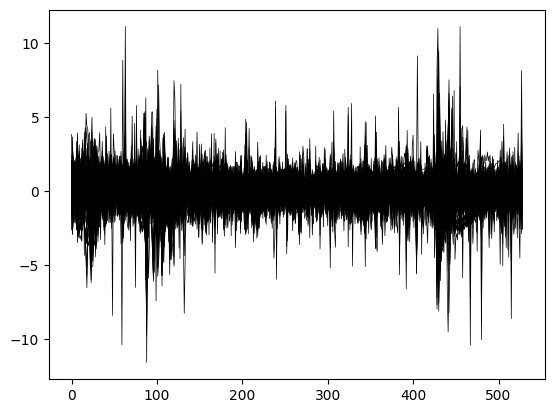

In [3]:
y = load_y()
plt.plot(y,c ='black', linewidth=.5);

In [4]:
y = load_y()
input_dim = y.shape[1]
factor_dim = 10
enc = Encoder(hidden_dim = [input_dim, 50, factor_dim], activation=nn.Tanh(), lastLayerLinear=False) 
dec = Decoder(hidden_dim = [factor_dim, input_dim], activation=nn.Identity())
model = AutoEncoder(enc, dec)
criterion = OrthoLoss(enc, alpha=1)
#criterion = nn.MSELoss()
model, train_hist = d2FMMCMC_iid(y=y, model=model, n_epoch=1, optimizer = optim.Adam(params=model.parameters(),lr=0.01), criterion= criterion)

-0.15870511800050735


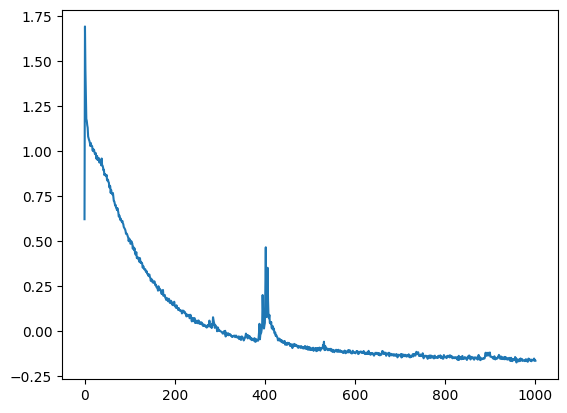

In [5]:
print(np.mean(train_hist['loss'][-50:]))
plt.plot(train_hist['loss'])

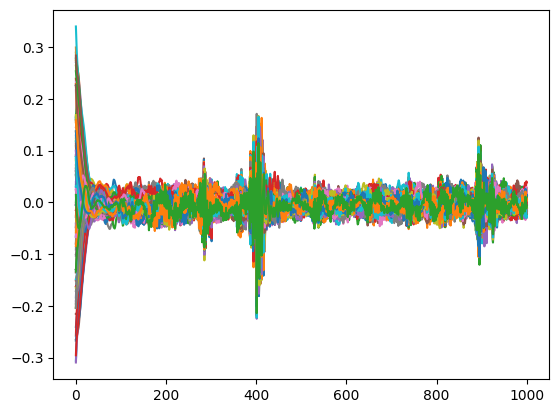

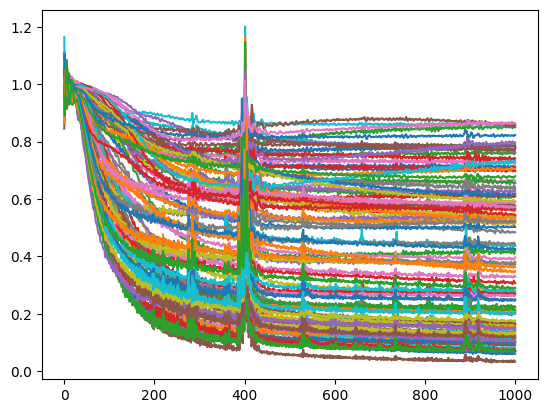

In [6]:
plt.plot(np.array(train_hist['mu_eps']));
plt.figure()
plt.plot(np.array(train_hist['var_eps']));

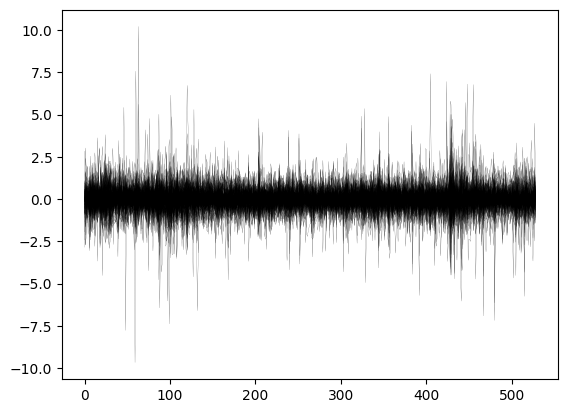

In [7]:
plt.plot(train_hist['eps'][-1], alpha = 1, color='black', linewidth=0.1);

In [72]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Assuming your data is stored in a n x d numpy array called `data`
# You can test for autocorrelation in each column of `data` as follows:

for i in range(train_hist['eps'][-1].shape[1]):
    series = train_hist['eps'][-1][:, i]  # Get the i-th column as a 1D array
    res = acorr_ljungbox(series, lags=10)
    print(f"Column {i+1} Ljung-Box test results:")
    print(f"Lagrange multiplier test statistic: {res['lb_stat']}")
    print(f"P-value: {res['lb_pvalue']}\n")

Column 1 Ljung-Box test results:
Lagrange multiplier test statistic: 1     102.471339
2     128.112248
3     143.880285
4     154.821429
5     162.059302
6     163.000881
7     165.834720
8     169.218823
9     182.045367
10    189.732660
Name: lb_stat, dtype: float64
P-value: 1     4.376539e-24
2     1.516278e-28
3     5.504543e-31
4     1.885077e-32
5     3.602583e-33
6     1.370108e-32
7     1.895036e-32
8     1.880147e-32
9     1.894809e-34
10    2.222373e-35
Name: lb_pvalue, dtype: float64

Column 2 Ljung-Box test results:
Lagrange multiplier test statistic: 1      80.953938
2      87.819912
3      87.821860
4      89.823561
5      90.515099
6      90.997806
7      92.711380
8      93.358511
9     101.172895
10    110.975991
Name: lb_stat, dtype: float64
P-value: 1     2.310407e-19
2     8.514290e-20
3     6.431764e-19
4     1.435442e-18
5     5.237323e-18
6     1.879896e-17
7     3.429251e-17
8     9.657724e-17
9     9.110513e-18
10    3.390929e-19
Name: lb_pvalue, dtype: float64

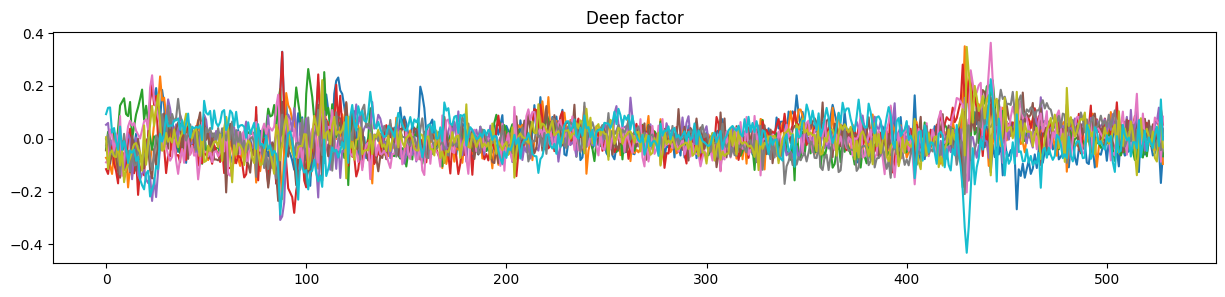

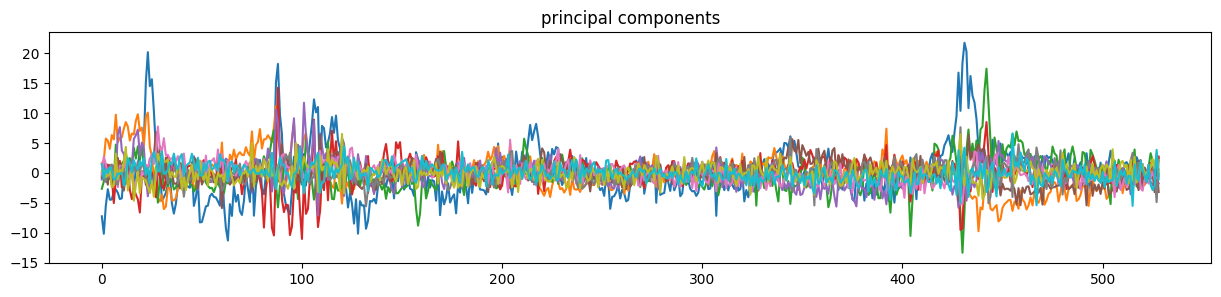

In [8]:
#plot factors
y_tensor = torch.from_numpy(y).float()
plt.figure(figsize=(15,3))
factors = model.enc(y_tensor).detach().numpy()
plt.plot(factors);
plt.title('Deep factor')

#compare to PCA
pca = PCA(n_components=factor_dim)
pc = pca.fit_transform(y)
plt.figure(figsize=(15,3))
plt.plot(pc);
plt.title('principal components')
np.save('factors_iid.npy', factors)

Text(0.5, 1.0, '$\\hat y$')

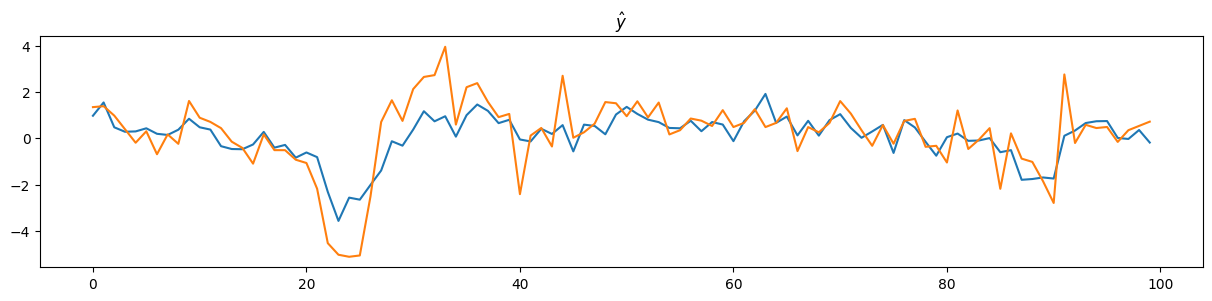

In [9]:
#plot reconstructed y_hat
plt.figure(figsize=(15,3))
y_hat = model(y_tensor).detach().numpy()
i = 100
plt.plot(y_hat[0:100,i]);
plt.plot(y[0:100,i])
plt.title('$\hat y$')

In [15]:
dim_z

529

In [16]:
y.shape

(529, 103)

In [19]:
Hx(ekf.x).shape

(103,)

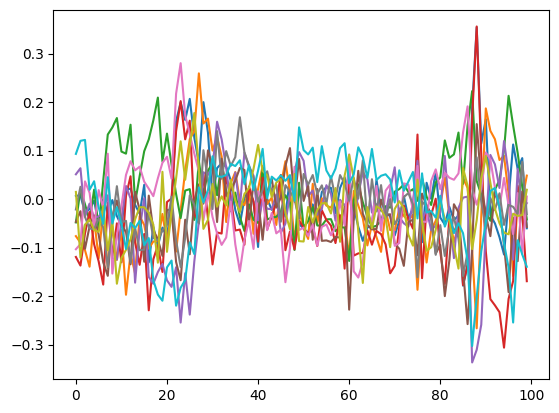

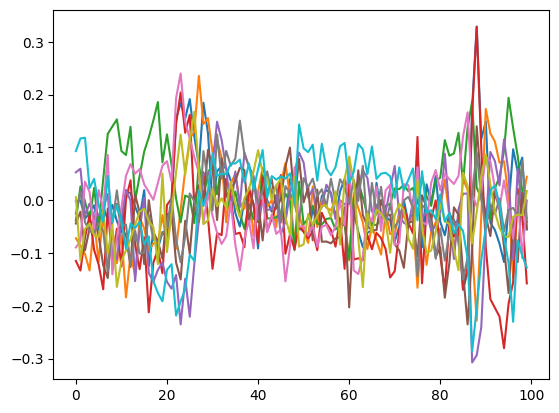

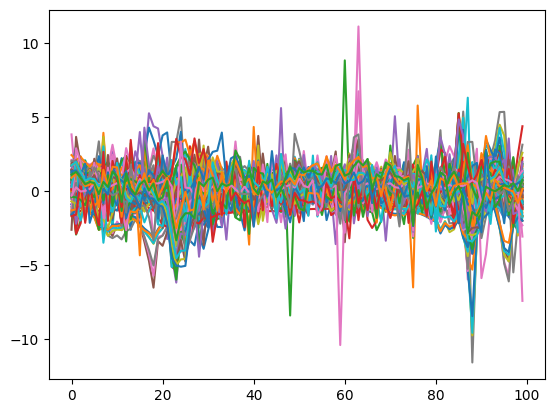

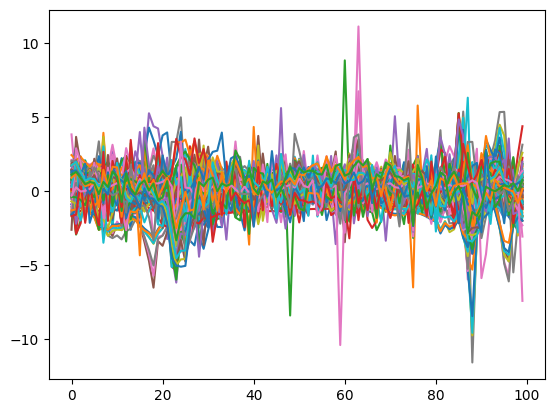

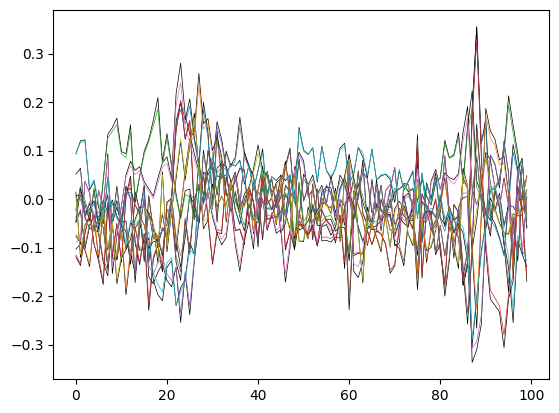

In [34]:
from filterpy.kalman import ExtendedKalmanFilter as ExtendedKalmanFilter
dim_x = factor_dim
dim_z = y.shape[1]
ekf = ExtendedKalmanFilter(dim_x, dim_z)
#ekf.R = np.ones((dim_z))
#ekf.Q = np.diag(np.ones(dim_z))
ekf.F = np.diag(np.ones(dim_x))
#ekf.P = np.diag(np.ones(dim_x))
ekf.x = factors[0]
decoder = model.dec
Hx = lambda state: decoder(torch.Tensor(state).float()).detach().numpy()
HJacobian = lambda state: jacobian(decoder,torch.Tensor(state).float()).detach().numpy()
xs = []
zs = []
for i in range(100):
    z = y[i,:]
    ekf.update(z, HJacobian, Hx)
    xs.append(ekf.x)
    ekf.predict()
    zs.append(ekf.z)

states = np.stack(xs)
plt.plot(np.stack(xs));
plt.figure()
plt.plot(factors[0:100]);
plt.figure()
plt.plot(np.stack(zs));
plt.figure()
plt.plot(y[0:100])
plt.figure()
plt.plot(np.stack(xs), linewidth=0.5,color='black');
plt.plot(factors[0:100], linewidth=0.5, color=None);

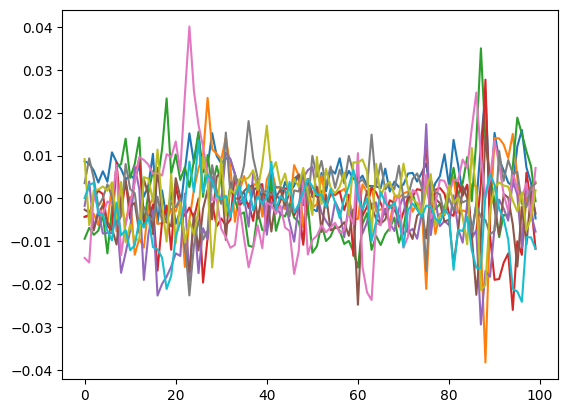

In [30]:
plt.plot(states-factors[0:100])

In [18]:
def init_eps(T:int,n:int):
    """
    Initinitalize idiosyncratic error terms.
    """
    #TODO: How to do this lol?
    return np.random.normal(size = (T,n))

def check_convergence(loss_hist: list, eps = 1e-10):
    if len(loss_hist) < 11:
        return False
    if len(loss_hist) > 1000:
        return True
    return ((np.array(loss_hist)[-11:-1] - np.array(loss_hist)[-10:]) < eps).all()

def d2FMMCMC(y: np.ndarray, model: AutoEncoder, n_epoch:int, optimizer: optim.Optimizer, criterion: nn.Module):
    n = y.shape[1]
    T = y.shape[0]
    eps = init_eps(T,n)
    phi = ArProcess(T,n,d=1).fit(eps)
    convergence = False
    hist_keys = ['loss', 'coeff', 'sigma2']
    train_hist = {k: [] for k in hist_keys}    
    y_tensor = torch.from_numpy(y).float()
    i = 0
    while not convergence:
        #train_hist['coeff'].append(phi.coefficients)
        #train_hist['sigma2'].append(phi.sigma2)

        y_tilde = y - phi.conditionalExpectation()
        for epoch in range(n_epoch):
            y_tilde_mc = y_tilde+phi.simulate()

            optimizer.zero_grad()
            model_in = torch.from_numpy(y_tilde_mc).float()
            out = model(model_in)
            loss  = criterion(out, model_in)
            loss.backward()
            optimizer.step()
            train_hist['loss'].append(loss.item())
        eps = y - model(y_tensor).detach().numpy()
        phi = ArProcess(T,n,d=1).fit(eps)
        print(i, train_hist['loss'][-1], end='\r')
        i+=1
        convergence = check_convergence(train_hist['loss'])
    return phi, model, train_hist

## Test on the data

In [24]:
y = load_y()
input_dim = y.shape[1]
factor_dim = 10
enc = Encoder(hidden_dim = [input_dim, factor_dim], activation=nn.Identity()) #fully linear
dec = Decoder(hidden_dim = [factor_dim, input_dim])
model = AutoEncoder(enc, dec)
model_opt = torch.compile(model)
phi, model, train_hist = d2FMMCMC(y=y, model=model_opt, n_epoch=1, optimizer = optim.Adam(params=model.parameters(),lr=0.01), criterion= nn.MSELoss())

RuntimeError: Python 3.11+ not yet supported for torch.compile

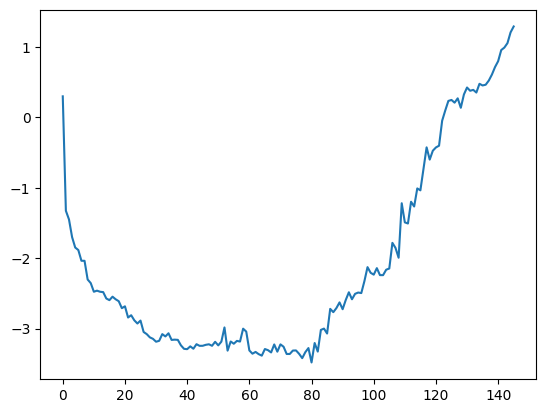

In [139]:
plt.plot(np.log(np.array(train_hist['loss'])))

Text(0.5, 1.0, 'principal components')

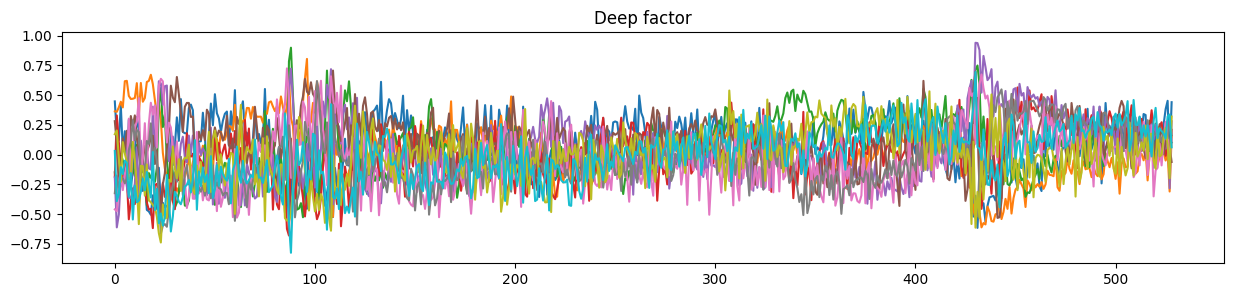

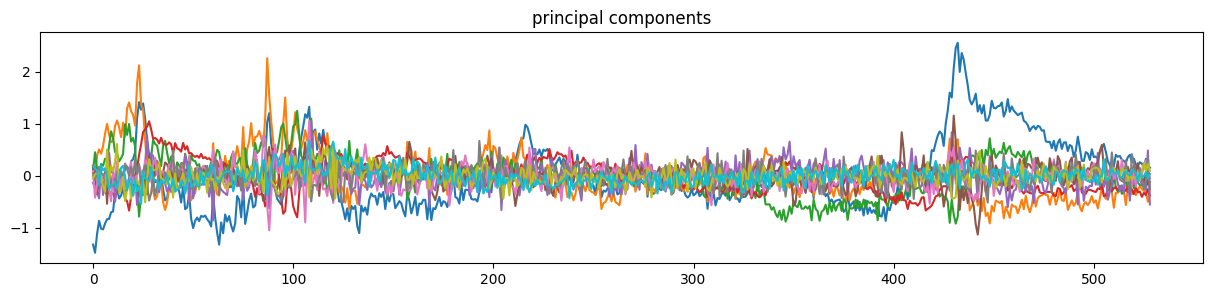

In [31]:
#plot factors
y_tensor = torch.from_numpy(y).float()
plt.figure(figsize=(15,3))
plt.plot(model.enc(y_tensor).detach().numpy());
plt.title('Deep factor')

#compare to PCA
pca = PCA(n_components=factor_dim)
pc = pca.fit_transform(y)
plt.figure(figsize=(15,3))
plt.plot(pc);
plt.title('principal components')

Text(0.5, 1.0, '$\\hat y$')

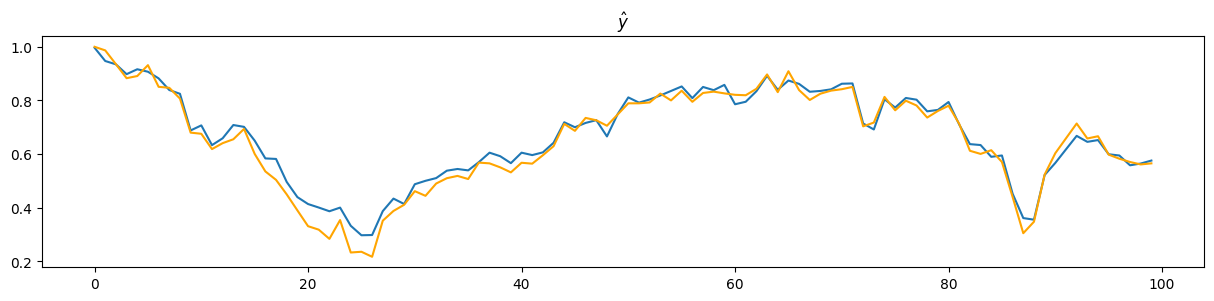

In [92]:
#plot reconstructed y_hat
plt.figure(figsize=(15,3))
y_hat = model(y_tensor).detach().numpy()
i = i+1
plt.plot(y_hat[0:100,i]);
plt.plot(y[0:100,i],c='orange')
plt.title('$\hat y$')